In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from DE_library import simulate_ODE, simulate_phase_portrait
import matplotlib.pyplot as plt

from MARBLE import utils, geometry, net, plotting

In [2]:
def initial_conditions(n, reps):
    X0_range = [geometry.sample_2d(n, [[-3,-3],[3,3]], 'random', seed=i) for i in range(reps)]
        
    return X0_range

def simulate_system(mu, X0):
    p, v = simulate_phase_portrait('vanderpol', t, X0, par = {'mu': mu})
    pos, vel = [], []
    for p_, v_ in zip(p,v):
        ind = np.where((abs(p_) < 3).all(1))[0]
        p_ = p_[ind,:]; v_ = v_[ind,:]
        ind = np.where((abs(v_) > 1e-10).any(1))[0]
        p_ = p_[ind,:]; v_ = v_[ind,:]
        ind = np.where((abs(p_) > 1e-1).all(1))[0]
        p_ = p_[ind,:]; v_ = v_[ind,:]
        pos.append(p_)
        vel.append(v_)
        
    return pos, vel

def plot_phase_portrait(pos, vel, ax=None, node_feature=None):
    if not isinstance(pos, list):
        pos = [pos]
    if not isinstance(vel, list):
        vel = [vel]

    for p, v in zip(pos, vel):
        ax = plotting.trajectories(p, v, ax=ax, style='>', node_feature=node_feature, lw=2, arrowhead=.1, axis=False, alpha=1.)
    ax.axis('square')
    
def reject_outliers(data, m=1):
    data = data.mean(1)
    return np.where(abs(data - np.median(data)) < m * np.std(data))[0]

def plot_embedding(emb, ax, slices, i, n_clusters=2):
    s = range(slices[i], slices[i+1])
    clusters = geometry.cluster(emb, cluster_typ='kmeans', n_clusters=n_clusters, seed=0)
    plotting.embedding(emb[s], clusters['labels'][s], ax=ax[0])
    plot_phase_portrait(pos_subsample[i], vel_subsample[i], ax[1], node_feature=clusters['labels'][s])

# For initial conditions, sample a rectangle uniformly

In [3]:
t0, t1, dt = 0, 3, 0.5
t = np.arange(t0, t1, dt)
n = 100

# Geneate phase portraits from random initial conditions while varying $\beta_1$

In [4]:
n_steps=10
beta1 = np.hstack((np.linspace(-.5,.5,n_steps)))

pos, vel = [], []
X0_range = initial_conditions(n, len(beta1))
for i, b1 in enumerate(beta1):
    p, v = simulate_system(b1, X0_range[i])
            
    pos.append(np.vstack(p))
    vel.append(np.vstack(v))

/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# Display state spaces under four different parameter conditions

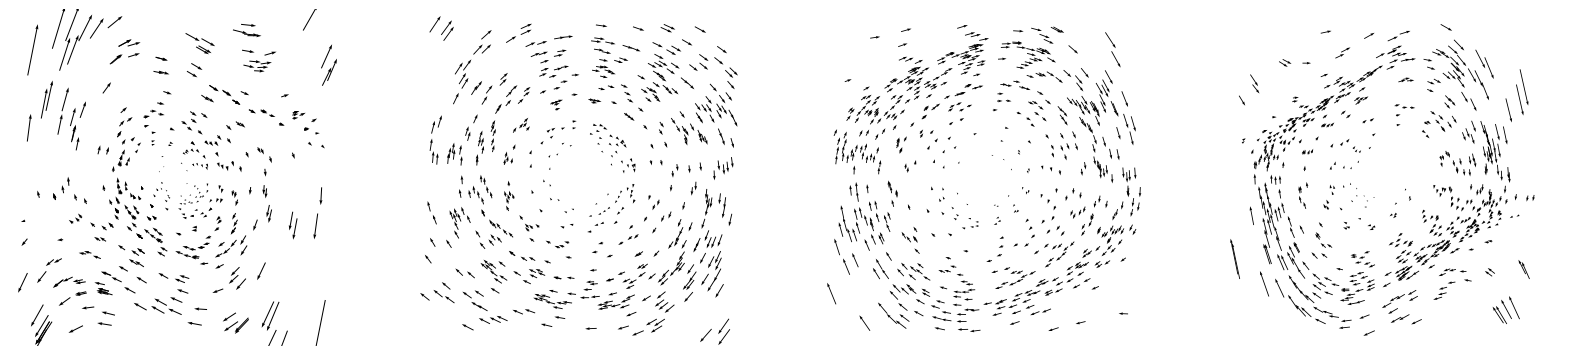

In [5]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
    
plot_phase_portrait(pos[0], vel[0], ax[0])
plot_phase_portrait(pos[n_steps//2-1], vel[n_steps//2-1], ax[1])
plot_phase_portrait(pos[n_steps//2+1], vel[n_steps//2+1], ax[2])
plot_phase_portrait(pos[-1], vel[-1], ax[3])

# Train network

In [6]:
k=15

data = utils.construct_dataset(pos, features=vel, graph_type='cknn', k=k, stop_crit=0.02)


---- Total # of points: 4809
---- # evenly sampled training points: 2865
---- # randomly sampled validation points: 286
---- # randomly test points: 287 



In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

par = {'batch_size': 64, #batch size
       'epochs': 40, #optimisation epochs
       'order': 2, #order of derivatives
       'n_lin_layers': 2,
       'hidden_channels': 16, #number of internal dimensions in MLP
       'out_channels': 3,
       'diffusion': False,
       'inner_product_features': True,
       'autoencoder': False
      }

model = net(data, **par)
model.run_training(data)

---- Settings: 

batch_size : 512
epochs : 40
order : 2
n_lin_layers : 2
hidden_channels : 16
out_channels : 3
diffusion : False
inner_product_features : True
autoencoder : False
lr : 0.01
vector : False
frac_geodesic_nb : 2.0
frac_sampled_nb : -1
var_explained : 0.9
diffusion_method : spectral
dropout : 0.0
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 2
dim_emb : 2
n_geodesic_nb : 30
n_sampled_nb : -1

---- Number of features to pass to the MLP:  7
---- Total number of parameters:  209
---- Treating features as scalar channels.

---- Training network ... 

Epoch: 1, Training loss: 1.3645, Validation loss: 1.3448
Epoch: 2, Training loss: 1.3090, Validation loss: 1.2928
Epoch: 3, Training loss: 1.2287, Validation loss: 1.2062
Epoch: 4, Training loss: 1.2118, Validation loss: 1.2253
Epoch: 5, Training loss: 1.1704, Validation loss: 1.2149
Epoch: 6, Training loss: 1.1541, Validation loss: 1.1985
Epoch: 7, Training loss: 1.1636, Validation loss: 1.1582

# Create embeddings

In [12]:
data = model.evaluate(data)

Performed MDS embedding on embedded results.


<AxesSubplot:>

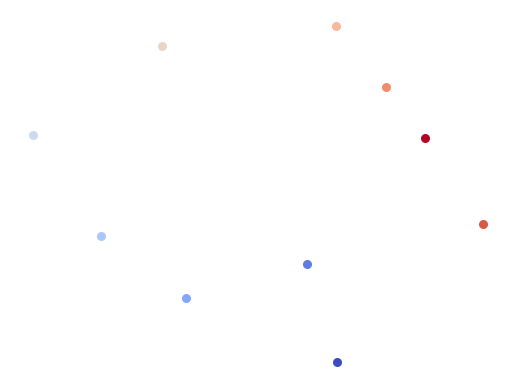

In [13]:
dist, gamma = geometry.compute_distribution_distances(data)
emb_MDS, _ = geometry.embed(dist, embed_typ = 'MDS')
plotting.embedding(emb_MDS, beta1, s=30, alpha=1)

# Distance matrix

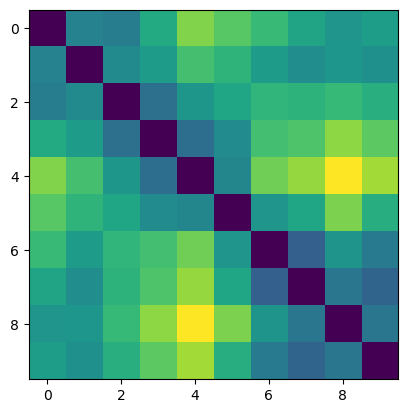

In [14]:
plt.imshow(dist)

# Cluster and visualise embedding

In [ ]:
emb, _ = geometry.embed(data.emb)
titles = [r'$\beta$ = {:0.2f}'.format(b) for b in beta1]
plotting.embedding(emb, data.y.numpy(), titles=titles)

In [ ]:
n_clusters=[2,4,6,8]
fig, ax = plt.subplots(len(n_clusters),4, figsize=(10,10))
slices=data._slice_dict['x']

snapshot=3
for i, n in enumerate(n_clusters):
    plot_embedding(emb, ax[:,:2][i], slices, snapshot, n_clusters=n)
    
snapshot=5
for i, n in enumerate(n_clusters):
    plot_embedding(emb, ax[:,2:][i], slices, snapshot, n_clusters=n)

In [ ]:
_, _, clusters, dist, gamma = geometry.cluster_embedding(data,cluster_typ='kmeans', embed_typ='umap', n_clusters=30)

In [ ]:
def compare_attractors(emb, pos, vel, source_target, clusters, gamma, ax=None):
    
    s, t = source_target
    slices = data._slice_dict['x']
    n_slices = len(slices)-1
    s_s = range(slices[s], slices[s+1])
    s_t = range(slices[t], slices[t+1])
    
    assert s<n_slices-2 and t<n_slices-1, 'Source and target must be < number of slices!'
    assert s!=t, 'Source and target must be different!'
    
    if ax is None:
        _, ax = plt.subplots(1,3, figsize=(10,5))
    
    #color code features
    gamma = gamma[s,t,...]
    np.fill_diagonal(gamma, 0.0)
    
    c = gamma.sum(1)
    cluster_ids = set(clusters['labels'][s_s])
    labels = [i for i in s_s]
    for cid in cluster_ids:
        idx = np.where(cid==clusters['labels'][s_s])[0]
        for i in idx:
            labels[i] = c[cid]
    
    plotting.embedding(emb, ax=ax[0], alpha=0.05)
    plotting.embedding(emb[s_s], labels=labels, ax=ax[0], alpha=1.)
    
    plot_phase_portrait(pos[s], vel[s], ax[1], node_feature=labels)
    
    c = gamma.sum(0)
    cluster_ids = set(clusters['labels'][s_t])
    labels = [i for i in s_t]
    for cid in cluster_ids:
        idx = np.where(cid==clusters['labels'][s_t])[0]
        for i in idx:
            labels[i] = -c[cid]
    
    plotting.embedding(emb[s_t], labels=labels, ax=ax[0], alpha=1.)
    
    plot_phase_portrait(pos[t], vel[t], ax[2], node_feature=labels)
    
compare_attractors(emb, pos_subsample, vel_subsample, (3,4), clusters, gamma)